## EDI Processing

In this notebook, we show the EDI processing in `blurbatteries` scene.

In [11]:
import os
import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from utils.event_utils import brightness_increment_image
import torchvision

def inner_double_integral(bii):
    assert bii.shape[0] % 2 == 0
    N = bii.shape[0] // 2

    images = []
    # Left part of the interval from f-T/2 to f
    for i in range(N):
        images.append(- bii[i:N].sum(axis=0))
    # Frame at f
    images.append(np.zeros_like(images[0]))
    # Right part of the interval from f to f+T/2
    for i in range(N):
        images.append(+ bii[N:N + 1 + i].sum(axis=0))

    images = np.stack(images, axis=0)
    return images


def deblur_double_integral(blurry, bii, idx=0):
    N = bii.shape[0] // 2
    
    images = inner_double_integral(bii)
    
    if idx == 4:
        sharp = ((2*N+1) * blurry / np.exp(images).sum(axis=0))
    elif idx < 4:
        sharp = ((2*N+1) * blurry / np.exp(images).sum(axis=0)) / np.exp(bii[idx:4].sum(axis=0))
    else:
        sharp = ((2*N+1) * blurry / np.exp(images).sum(axis=0)) * np.exp(bii[4:idx+1].sum(axis=0))
    return sharp

with open("data/ev-deblurnerf_cdavis/blurbatteries/events/image_start.pickle", "rb") as f:
    start = pickle.load(f)
with open("data/ev-deblurnerf_cdavis/blurbatteries/events/image_end.pickle", "rb") as f:
    end = pickle.load(f)
with open("data/ev-deblurnerf_cdavis/blurbatteries/events/events.pickle", "rb") as f:
    ev = pickle.load(f)
with open("data/ev-deblurnerf_cdavis/blurbatteries/events/id_to_coords.pickle", "rb") as f:
    id_to_coords = pickle.load(f)

all_tms = []
for tms_start, tms_end in zip(start, end):
    all_tms.append(np.linspace(tms_start, tms_end, 9))

all_tms = torch.tensor(np.concatenate(all_tms))
ev_tms = ev[:, 1]

IMAGE_NUM = 18

idx_events_left = torch.searchsorted(ev_tms, all_tms).reshape(IMAGE_NUM, 9)
idx_events_right = torch.searchsorted(ev_tms, all_tms, side="right").reshape(IMAGE_NUM, 9)

EDI_IMAGES = []
BLURRY_IMAGES = []
for j in range(IMAGE_NUM):
    blurry_image = Image.open("data/ev-deblurnerf_cdavis/blurbatteries/images/" + '{0:02d}'.format(j) + ".png")
    blurry_image = np.array(blurry_image) / 255.
    
    BLURRY_IMAGES.append(blurry_image)

    bii_list = []
    for i in range(8):
        idx_left = idx_events_left[j, i]
        idx_right = idx_events_right[j, i+1]
        ev_ = ev[idx_left:idx_right]
        x, y = id_to_coords[ev_[:, 0].long()].T.cpu().numpy()
        p = ev_[:, 2].cpu().numpy()

        bii = brightness_increment_image(x, y, p, 346, 260, 0.25, 0.25, interpolate=True, threshold=True)  # [H, W] -> 346, 260
        bii = bii[:, :, None].repeat(3, axis=-1)

        bii_list.append(bii)
    bii = np.stack(bii_list, axis=0)

    for i in range(9):
        edi = deblur_double_integral(blurry_image, bii, idx=i)
        edi = torch.from_numpy(edi)
        
        EDI_IMAGES.append(edi)
        # torchvision.utils.save_image(edi.permute(2, 0, 1), "/data/sjlee/DiET-GS/upload_data/ev-deblurnerf_blender/blurwine/images_edi/" + str(j) + "_" + str(i) + ".png")


Now, lets check the deblurred image!

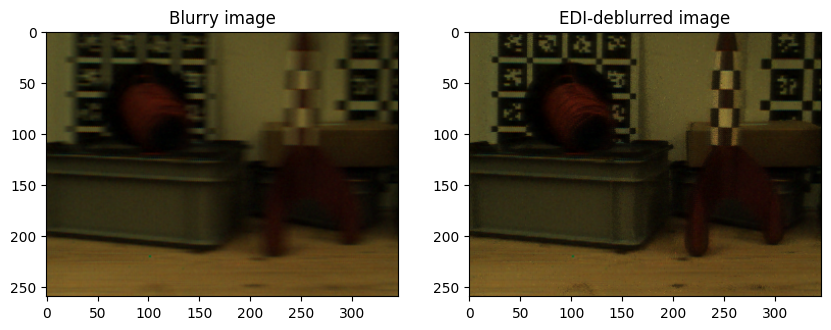

In [ ]:
idx = 0

plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.title("Blurry image")
plt.imshow(BLURRY_IMAGES[idx])
plt.subplot(1, 2, 2)
plt.title("EDI-deblurred image")
plt.imshow(EDI_IMAGES[idx * 9 + 4])